<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anime EDA Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

anime_pd = pd.read_csv('/content/top_anime_dataset.csv')

In [2]:
import datetime as dt

# convert to number and replace str members with null

anime_pd['Members'] = anime_pd['Members'].apply(lambda x: x.replace('members', ''))
anime_pd['Members'] = anime_pd['Members'].apply(lambda x: x.replace(',', ''))
anime_pd['Members'] = anime_pd['Members'].astype(int)

# # split poularity and create 2 columns start and end date
#Sep 2016 - Sep 2016

anime_pd['Popularity'] = anime_pd['Popularity'].apply(lambda x: x.split('-')) #if ' - ' in x else [x, np.nan])
anime_pd['Start_Date'] = anime_pd['Popularity'].apply(lambda x: x[0]).apply(lambda x: x.strip())
anime_pd['End_Date'] =   anime_pd['Popularity'].apply(lambda x: x[1]
                                                      if len(x) > 1
                                                      else dt.date.today().year).apply(lambda x: x.strip())

# get indexes for end date values null and replace those records with start date

null_end_date_indexes = anime_pd[anime_pd['End_Date'].eq('')].index
anime_pd.loc[null_end_date_indexes, 'End_Date'] = anime_pd.loc[null_end_date_indexes, 'Start_Date']

# check if the date contains numbers or strings

def convert_to_date(date_string):
  import re
  if re.search('[a-zA-Z]', date_string):
      pass
  else:
      date_string = "Jan " + date_string
  return date_string


anime_pd['Start_Date'] = anime_pd['Start_Date'].apply(lambda x: convert_to_date(x))
anime_pd['End_Date'] = anime_pd['End_Date'].apply(lambda x: convert_to_date(x))

anime_pd = anime_pd.drop(anime_pd[anime_pd['Start_Date'].str.strip() == 'Jan'].index)


from datetime import datetime

def caluclate_Duration(start_date, end_date):
  start_date = datetime.strptime(start_date, "%b %Y")
  end_date = datetime.strptime(end_date, "%b %Y")
  duration = (end_date - start_date)
  duration = (duration.days)/30
  return duration

anime_pd['Duration'] = anime_pd.apply(lambda x: caluclate_Duration(x['Start_Date'], x['End_Date']), axis=1)


anime_pd['movie_type'] = anime_pd['Type'].map({'TV': 1, 'Movie': 2, 'OVA': 3, 'Special': 4, 'ONA': 5})

In [4]:
y = anime_pd['Rating']
X = anime_pd[['Ranked','Members','movie_type','Duration']]

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.2)




In [5]:
import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.001,
    'lambda': 1,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor'
    }


xgb_model = xgb.XGBRegressor(random_state=42, params=params)
xgb_model.fit(train_X, train_y)
y_pred = xgb_model.predict(test_X)

# # convert y_pred to dataframe assing text_X indexes to y_pred

df = pd.DataFrame(y_pred, index = test_X.index, columns=['Predicted rating'])

# join df and test_y using index

joined_df =df.join(test_y, how = 'inner')


from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# # convert y_pred to dataframe assing text_X indexes to y_pred

df = pd.DataFrame(y_pred, index = test_X.index, columns=['Predicted rating'])

# join df and test_y using index

joined_df =df.join(test_y, how = 'inner')
joined_df

Mean Squared Error: 0.0004182052322081677
R-squared: 0.9989876177962809


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)


,Predicted rating,Rating
4122,7.052067,7.04
4065,7.060679,7.06
1731,7.558650,7.55
4740,6.909606,6.91
6391,6.604777,6.61
...,...,...
3799,7.116229,7.11
8284,6.289797,6.29
7851,6.360301,6.36
1095,7.778345,7.77


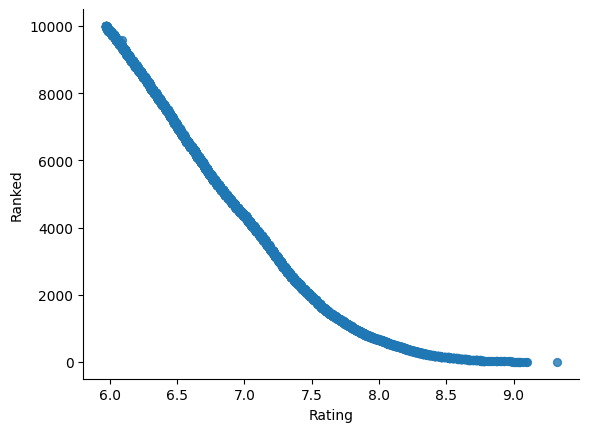

In [ ]:
# @title Rating vs Ranked

from matplotlib import pyplot as plt
anime_pd.plot(kind='scatter', x='Rating', y='Ranked', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# more poularity of visuals are comming from TV

# There are 10K records

In [ ]:
anime_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        9998 non-null   object 
 1   Rating      9998 non-null   float64
 2   Ranked      9998 non-null   int64  
 3   Popularity  9998 non-null   object 
 4   Members     9998 non-null   int64  
 5   End_Date    9998 non-null   object 
 6   Duration    9998 non-null   float64
 7   movie_type  9997 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 961.0+ KB


<Axes: >

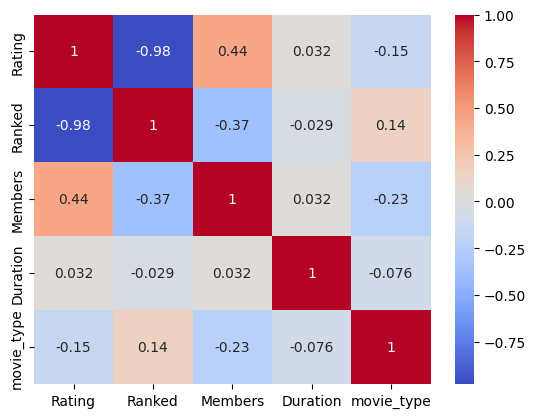

In [ ]:
# correlation matrix  for numberical variables

numerical = anime_pd.select_dtypes(include=[np.number])
numerical_corr = numerical.corr()

# show matrix

sns.heatmap(numerical_corr, cmap='coolwarm', annot=True)


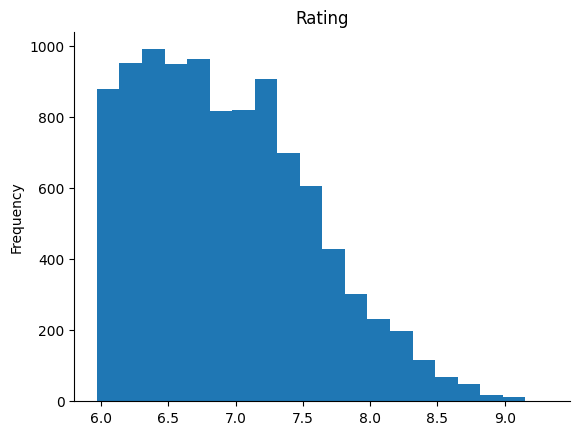

In [ ]:
# @title rating distribution

anime_pd['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

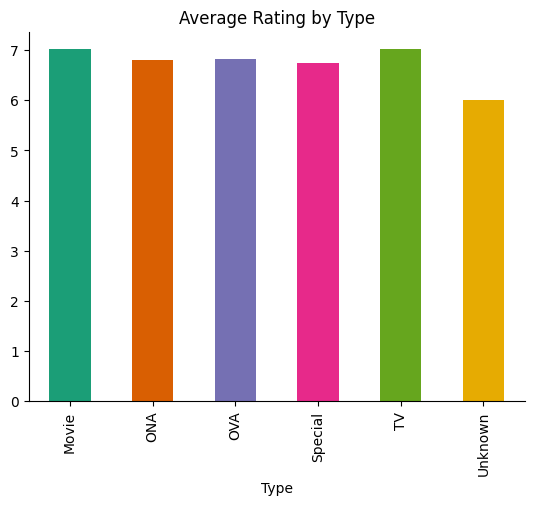

In [ ]:
# where are the highest ratings commming from , by type, # members watched and rankings

anime_pd.groupby('Type')['Rating'].mean().plot(kind='bar',
                                               color=sns.palettes.mpl_palette('Dark2'),
                                               title='Average Rating by Type',
                                               )
plt.gca().spines[['top', 'right',]].set_visible(False)


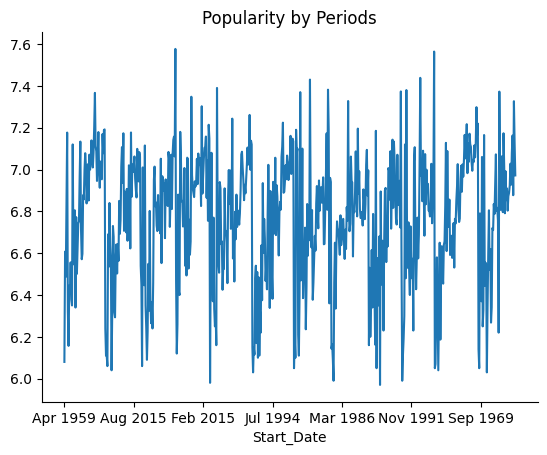

In [ ]:
# check popularity by periods

anime_pd.groupby('Start_Date')['Rating'].mean().plot(kind='line', title='Popularity by Periods')
plt.gca().spines[['top', 'right',]].set_visible(False)

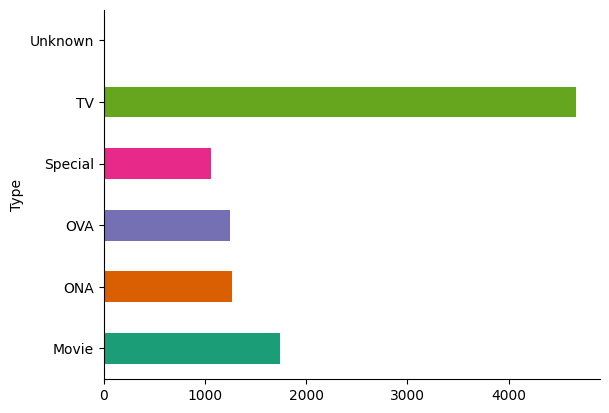

In [ ]:
# @title Type

from matplotlib import pyplot as plt
import seaborn as sns
anime_pd.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


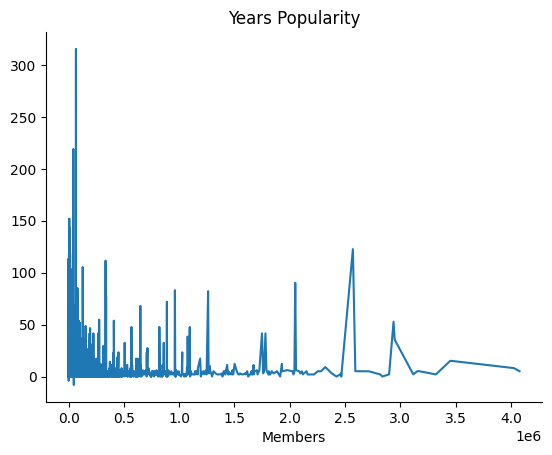

In [ ]:
# @title over years members count

years_popularity = anime_pd.groupby('Members')['Duration'].mean()
years_popularity.plot(kind='line', title='Years Popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)


In [ ]:
# @title Count of top 20 members by Animes

top_20_members = anime_pd.nlargest(20, 'Members')
top_20_members.plot(kind='barh', x='Name', y='Members', color=sns.palettes.mpl_palette('Dark2'), title='Top 20 Members by Animes')
plt.gca().spines[['top', 'right',]].set_visible(False)


In [ ]:
anime_pd

,Name,Rating,Ranked,Popularity,Members,End_Date,Duration,movie_type
0,Sousou no Frieren,9.32,1,"[Sep 2023 , Mar 2024]",974075,Mar 2024,6.066667,1.0
1,Fullmetal Alchemist: Brotherhood,9.10,2,"[Apr 2009 , Jul 2010]",3452671,Jul 2010,15.200000,1.0
2,One Piece Fan Letter,9.09,3,"[Oct 2024 , Oct 2024]",73667,Oct 2024,0.000000,1.0
3,Steins;Gate,9.07,4,"[Apr 2011 , Sep 2011]",2645303,Sep 2011,5.100000,1.0
4,Shingeki no Kyojin Season 3 Part 2,9.05,5,"[Apr 2019 , Jul 2019]",2379562,Jul 2019,3.033333,1.0
...,...,...,...,...,...,...,...,...
9995,Kaiko sareta Ankoku Heishi (30-dai) no Slow na...,5.97,9996,"[Jan 2023 , Apr 2023]",1766,Apr 2023,3.000000,5.0
9996,Kidou Senshi Gundam 00 CB Chara,5.97,9997,"[Jul 2008 , Aug 2009]",639,Aug 2009,13.200000,4.0
9997,Manga Nippon Mukashibanashi (Movie),5.97,9998,"[Mar 1982 , Mar 1982]",555,Mar 1982,0.000000,2.0
9998,Minna Atsumare! Falcom Gakuen,5.97,9999,"[Jan 2014 , Mar 2014]",6057,Mar 2014,1.966667,1.0


<Axes: >

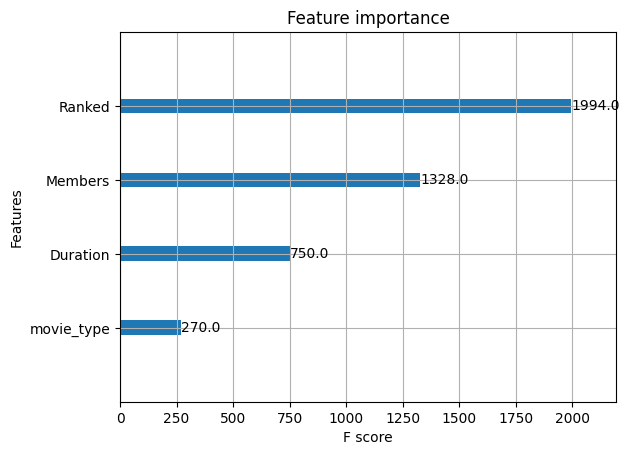

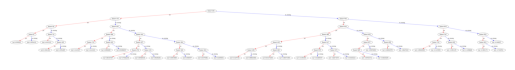

In [ ]:
# visualize xgb model tree

from xgboost import plot_importance
plot_importance(xgb_model)

# visualize xgb model tree

from xgboost import plot_tree
plot_tree(xgb_model, num_trees=1 )


# Multi-variate Analysis

In [ ]:
anime_pd.head()

,Name,Rating,Ranked,Popularity,Members,Type,Start_Date,End_Date,Duration
0,Sousou no Frieren,9.32,1,"[Sep 2023 , Mar 2024]",974075,TV,Sep 2023,Mar 2024,6.066667
1,Fullmetal Alchemist: Brotherhood,9.10,2,"[Apr 2009 , Jul 2010]",3452671,TV,Apr 2009,Jul 2010,15.200000
2,One Piece Fan Letter,9.09,3,"[Oct 2024 , Oct 2024]",73667,TV,Oct 2024,Oct 2024,0.000000
3,Steins;Gate,9.07,4,"[Apr 2011 , Sep 2011]",2645303,TV,Apr 2011,Sep 2011,5.100000
4,Shingeki no Kyojin Season 3 Part 2,9.05,5,"[Apr 2019 , Jul 2019]",2379562,TV,Apr 2019,Jul 2019,3.033333


In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

model = ols('Rating ~ Type + Duration', data=anime_pd).fit()
annova_table = sm.stats.anova_lm(model, typ=2)
print(annova_table)


               sum_sq      df          F        PR(>F)
Type       110.906121     5.0  57.000398  1.181295e-58
Duration     3.871176     1.0   9.947990  1.615023e-03
Residual  3887.913408  9991.0        NaN           NaN


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


if annova_table['PR(>F)'][0] < 0.05:
  m_comp = pairwise_tukeyhsd(anime_pd['Rating'], anime_pd['Type'], alpha=0.05)
  print(m_comp)

<ipython-input-77-c54a722815c8>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if annova_table['PR(>F)'][0] < 0.05:


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Movie     ONA  -0.2046    0.0 -0.2702  -0.139   True
  Movie     OVA  -0.1877    0.0 -0.2536 -0.1218   True
  Movie Special  -0.2624    0.0 -0.3316 -0.1932   True
  Movie      TV  -0.0004    1.0 -0.0503  0.0495  False
  Movie Unknown  -1.0061 0.5908 -2.7854  0.7732  False
    ONA     OVA   0.0169 0.9841 -0.0539  0.0878  False
    ONA Special  -0.0578 0.2251 -0.1317  0.0162  False
    ONA      TV   0.2042    0.0   0.148  0.2605   True
    ONA Unknown  -0.8015 0.7941 -2.5811   0.978  False
    OVA Special  -0.0747 0.0474 -0.1489 -0.0005   True
    OVA      TV   0.1873    0.0  0.1307  0.2439   True
    OVA Unknown  -0.8185 0.7791  -2.598  0.9611  False
Special      TV    0.262    0.0  0.2015  0.3225   True
Special Unknown  -0.7438 0.8413 -2.5234  1.0359  False
     TV Unknown  -1.0058  0.591 -2.7848  0.7733  False
----------